In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import ast
import networkx as nx
from collections import Counter
os.chdir("./../..")
print(os.getcwd())



/Users/adamouazzani/Documents/GitHub/ada-2024-project-theadacuates


In [25]:
df_processed = pd.read_csv('./data/output/processed_data/paths_processed.csv', low_memory=False)
df_raw = pd.read_csv('data/output/processed_data/unfiltered_paths_processed.csv', low_memory=False)
df_categories = pd.read_csv('data/output/processed_data/categories_processed.csv', low_memory=False)


# 1. Compare Row counts

In [14]:
# Get the total number of rows in the raw data
raw_row_count = df_raw.shape[0]

# Get the total number of rows in the processed data
processed_row_count = df_processed.shape[0]

# Calculate the number of paths removed during preprocessing
removed_paths = raw_row_count - processed_row_count

print(f"Total rows in raw data: {raw_row_count}")
print(f"Total rows in processed data: {processed_row_count}")
print(f"Paths removed during preprocessing: {removed_paths}")


Total rows in raw data: 76193
Total rows in processed data: 74114
Paths removed during preprocessing: 2079


# 2. Compare Path Completion Status

In [15]:
# Count finished vs. unfinished paths in raw data
raw_finished_counts = df_raw['finished'].value_counts()
print("Raw Data - Finished/Unfinished Counts:\n", raw_finished_counts)

# Count finished vs. unfinished paths in processed data
processed_finished_counts = df_processed['finished'].value_counts()
print("Processed Data - Finished/Unfinished Counts:\n", processed_finished_counts)


Raw Data - Finished/Unfinished Counts:
 finished
True     51318
False    24875
Name: count, dtype: int64
Processed Data - Finished/Unfinished Counts:
 finished
True     51280
False    22834
Name: count, dtype: int64


# 3. Check Balance between finished and unfinished path


In [5]:
# Calculate percentage of finished vs. unfinished paths in each dataset
raw_finished_ratio = raw_finished_counts[True] / raw_row_count
processed_finished_ratio = processed_finished_counts[True] / processed_row_count

print(f"Percentage of finished paths in raw data: {raw_finished_ratio:.2%}")
print(f"Percentage of finished paths in processed data: {processed_finished_ratio:.2%}")


Percentage of finished paths in raw data: 67.35%
Percentage of finished paths in processed data: 69.19%


# 4. Find Most Visited pages in the game

In [16]:
# Convert path_list strings to actual lists
df_processed['resolved_path_list_name'] = df_processed['resolved_path_list_name'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of pages and count occurrences of each page
all_pages = [page for path in df_processed['resolved_path_list_name'] for page in path]
page_counts = Counter(all_pages)

# Display the top 20 most frequent pages
top_20_pages = page_counts.most_common(20)
print("Top 20 Most Frequent Pages (Hubs):\n", top_20_pages)


Top 20 Most Frequent Pages (Hubs):
 [('United States', 13951), ('Europe', 6046), ('United Kingdom', 5888), ('England', 5054), ('Earth', 4521), ('Africa', 4001), ('World War II', 3151), ('North America', 2761), ('Animal', 2683), ('Mammal', 2661), ('Human', 2661), ('Brain', 2571), ('France', 2419), ('Germany', 2350), ('English language', 2173), ('Computer', 2151), ('Plant', 2071), ('Theatre', 2030), ('Agriculture', 2020), ('Science', 2019)]


In [17]:
# Flatten the list of pages and count occurrences of each page
all_pages = [page for path in df_processed['resolved_path_list_name'] for page in path]
page_counts = Counter(all_pages)

# Calculate total visits across all pages
total_visits = sum(page_counts.values())

# Calculate the visits for the top 20 pages
top_20_visits = sum(count for page, count in top_20_pages)

# Calculate the proportion of visits accounted for by the top 20 pages
top_20_proportion = top_20_visits / total_visits

print(f"\nThe Top 20 pages account for {top_20_proportion:.2%} of total visits in the game.")



The Top 20 pages account for 15.47% of total visits in the game.


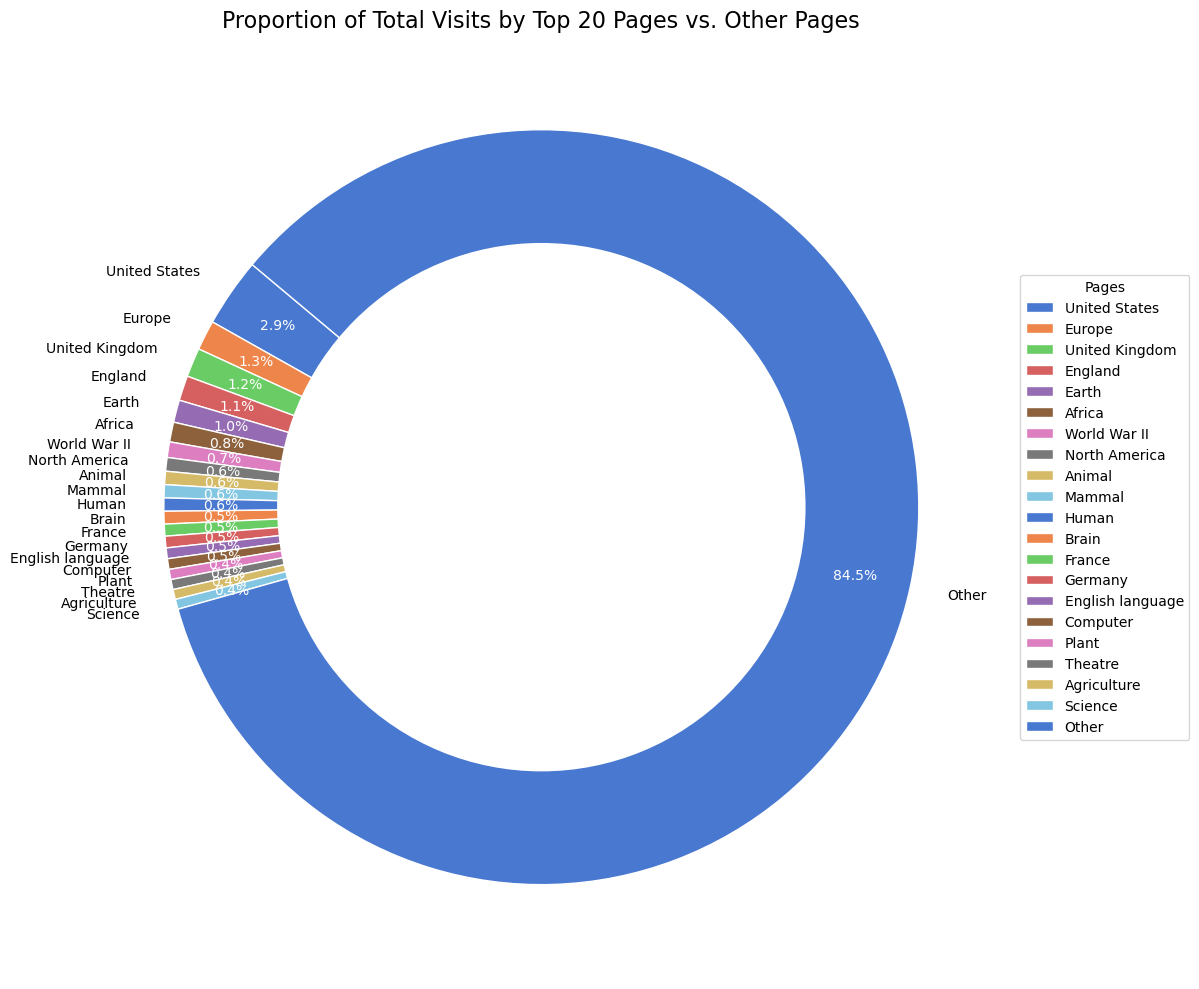

In [18]:
# Extract data for the top 20 pages
top_20_labels = [page for page, count in top_20_pages]
top_20_counts = [count for page, count in top_20_pages]

# Calculate the "Other" category for pages not in the top 20
other_count = total_visits - top_20_visits

# Add "Other" to the labels and counts
top_20_labels.append('Other')
top_20_counts.append(other_count)

colors = sns.color_palette('muted', len(top_20_labels))

# Plot a donut chart
plt.figure(figsize=(12, 10))
wedges, texts, autotexts = plt.pie(
    top_20_counts,
    labels=top_20_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.85, 
    wedgeprops={'edgecolor': 'w'}
)

# Draw a circle at the center
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Improve text properties for readability
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('white')

# Add a legend
plt.legend(wedges, top_20_labels, title="Pages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Add title
plt.title('Proportion of Total Visits by Top 20 Pages vs. Other Pages', fontsize=16)
plt.tight_layout()
plt.show()

# 5. Number of ingoing and outgoing links for the top hubs (# of times player clicked on the page, # of times a player quit the page)

In [19]:
df_processed['resolved_path_list_name'] = df_processed['resolved_path_list_name'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of all links to get outgoing and ingoing link pairs
outgoing_links = []
ingoing_links = []

for path in df_processed['resolved_path_list_name']:
    for i in range(len(path) - 1):
        source = path[i]
        target = path[i + 1]
        outgoing_links.append(source)
        ingoing_links.append(target)

# Count outgoing and ingoing links
outgoing_counts = Counter(outgoing_links)
ingoing_counts = Counter(ingoing_links)

# Display outgoing and ingoing links for the top 20 pages
top_20_pages = [page for page, count in page_counts.most_common(20)]
print("Top 20 Pages - Ingoing and Outgoing Links:")
for page in top_20_pages:
    outgoing_count = outgoing_counts.get(page, 0)
    ingoing_count = ingoing_counts.get(page, 0)
    print(f"{page}: Outgoing Links = {outgoing_count}, Ingoing Links = {ingoing_count}")

Top 20 Pages - Ingoing and Outgoing Links:
United States: Outgoing Links = 13265, Ingoing Links = 13902
Europe: Outgoing Links = 5830, Ingoing Links = 6007
United Kingdom: Outgoing Links = 5562, Ingoing Links = 5867
England: Outgoing Links = 4663, Ingoing Links = 4916
Earth: Outgoing Links = 4330, Ingoing Links = 4480
Africa: Outgoing Links = 3820, Ingoing Links = 3907
World War II: Outgoing Links = 2975, Ingoing Links = 3117
North America: Outgoing Links = 2594, Ingoing Links = 2718
Animal: Outgoing Links = 2505, Ingoing Links = 2644
Mammal: Outgoing Links = 2459, Ingoing Links = 2652
Human: Outgoing Links = 2513, Ingoing Links = 2620
Brain: Outgoing Links = 2359, Ingoing Links = 558
France: Outgoing Links = 2241, Ingoing Links = 2397
Germany: Outgoing Links = 2206, Ingoing Links = 2296
English language: Outgoing Links = 2016, Ingoing Links = 2152
Computer: Outgoing Links = 1975, Ingoing Links = 1950
Plant: Outgoing Links = 1936, Ingoing Links = 2042
Theatre: Outgoing Links = 1866, In

# 6. Categories

In [26]:
# Load categories data 
df_categories = df_categories[['article_name', 'article_category_1']]
df_categories = df_categories.rename(columns={'article_category_1': 'primary_category'})

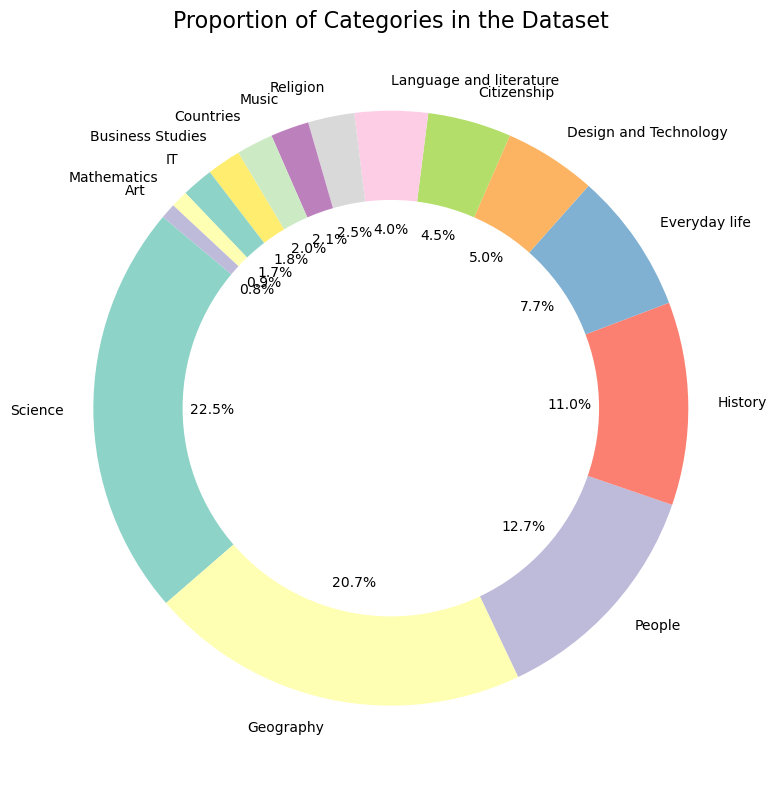

In [27]:
# Count the occurrences of each category before merging
category_counts = df_categories['primary_category'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette('Set3', len(category_counts))  # Choose a color palette
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Draw a circle at the center to make it a donut chart (optional)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Add title and adjust layout
plt.title('Proportion of Categories in the Dataset', fontsize=16)
plt.tight_layout()
plt.show()

# 7. Start and End Category

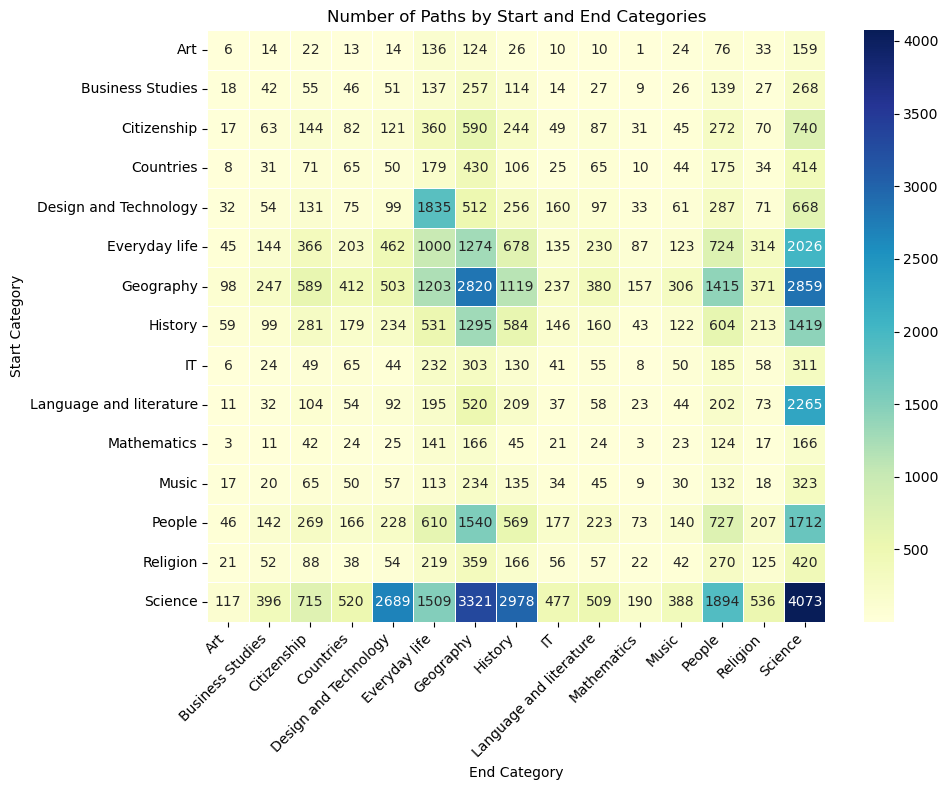

In [29]:
# Remove duplicates to ensure each article has a unique category
df_categories = df_categories.drop_duplicates(subset=['article_name'])

# Merge to add start category based on `source_link`
df_processed = df_processed.merge(
    df_categories,
    left_on='source_link',
    right_on='article_name',
    how='left'
).rename(columns={'primary_category': 'start_category'})

# Merge to add end category based on `target_link`
df_processed = df_processed.merge(
    df_categories,
    left_on='target_link',
    right_on='article_name',
    how='left'
).rename(columns={'primary_category': 'end_category'})

# Drop redundant columns from merging
df_processed = df_processed.drop(columns=['article_name_x', 'article_name_y'])

# Count paths that start in one category and end in another
category_path_counts = df_processed.groupby(['start_category', 'end_category']).size().unstack(fill_value=0)

# Plot a heatmap of the category path counts
plt.figure(figsize=(10, 8))
sns.heatmap(category_path_counts, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title("Number of Paths by Start and End Categories")
plt.xlabel("End Category")
plt.ylabel("Start Category")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 8. Transition Probability For Categories

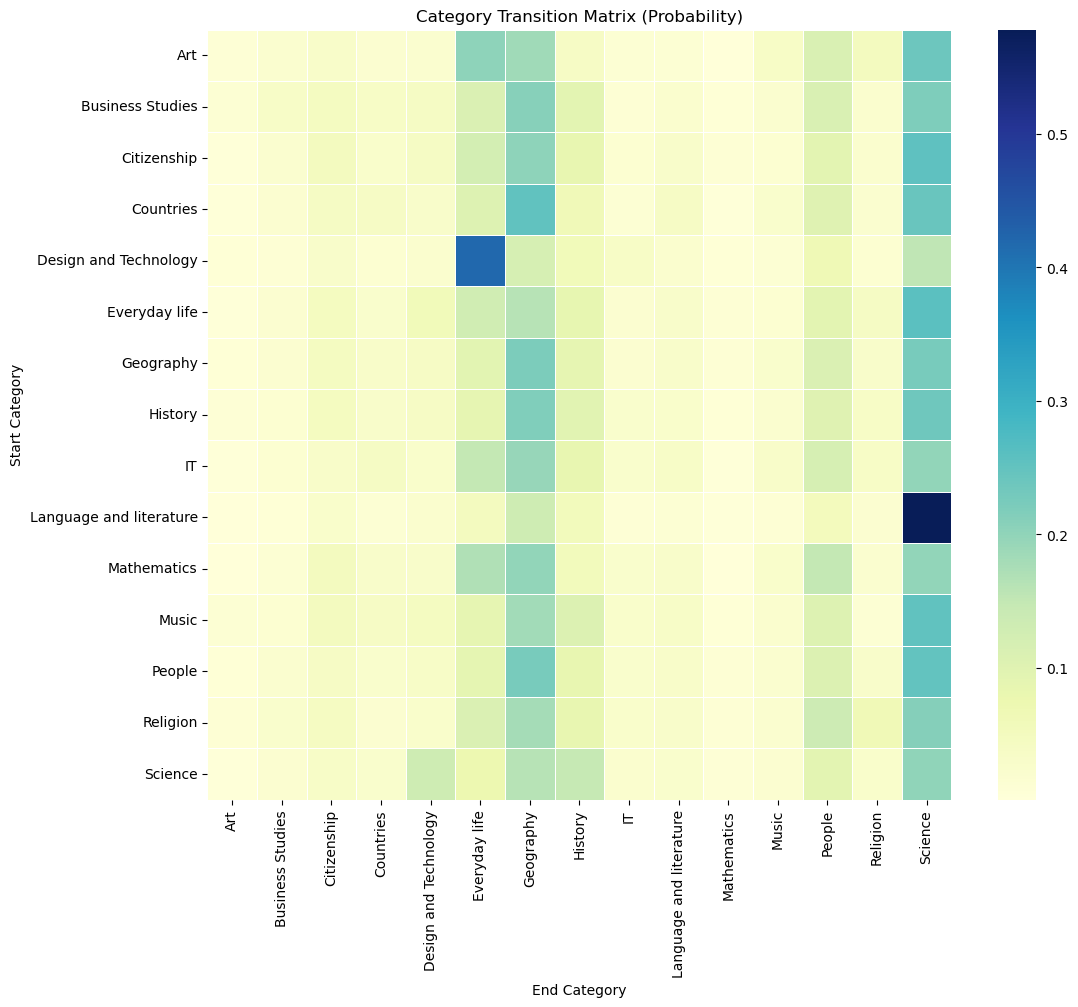

Top Category Flows:
              start_category           end_category  transition_count
224                  Science                Science              4073
216                  Science              Geography              3321
217                  Science                History              2978
104                Geography                Science              2859
96                 Geography              Geography              2820
214                  Science  Design and Technology              2689
149  Language and literature                Science              2265
89             Everyday life                Science              2026
222                  Science                 People              1894
65     Design and Technology          Everyday life              1835


In [31]:
#Create the Transition Matrix

# Count the number of transitions from each start category to each end category
transition_counts = df_processed.groupby(['start_category', 'end_category']).size().unstack(fill_value=0)

# Convert counts to probabilities (each row will sum to 1)
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Visualize the Transition Matrix with a Heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(transition_matrix, annot=False, cmap='YlGnBu', linewidths=0.5)
plt.title('Category Transition Matrix (Probability)')
plt.xlabel('End Category')
plt.ylabel('Start Category')
plt.show()

# Track Category Flow from Start to End

# Sum the transitions for each starting category to see the flow into each ending category
category_flow = df_processed.groupby(['start_category', 'end_category']).size().reset_index(name='transition_count')

# Get the top N flows for better visualization (e.g., top 10)
top_flows = category_flow.sort_values(by='transition_count', ascending=False).head(10)

# Display top flows
print("Top Category Flows:")
print(top_flows)